In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Resources/combined_cleaned.csv")
df.head()

,id,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.0,satisfied


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129487 non-null  int64  
 1   gender                             129487 non-null  object 
 2   customer_type                      129487 non-null  object 
 3   age                                129487 non-null  int64  
 4   type_of_travel                     129487 non-null  object 
 5   travel_class                       129487 non-null  object 
 6   flight_distance                    129487 non-null  int64  
 7   inflight_wifi_service              129487 non-null  int64  
 8   departure/arrival_time_convenient  129487 non-null  int64  
 9   ease_of_online_booking             129487 non-null  int64  
 10  gate_location                      129487 non-null  int64  
 11  food_and_drink                     1294

In [12]:
df["arrival_delay_in_minutes"] = df["arrival_delay_in_minutes"].astype('int')

## PREPROCESSING

In [4]:
# Imputing

df.drop(columns=["id"], inplace=True)

In [5]:
df.columns

Index(['gender', 'customer_type', 'age', 'type_of_travel', 'travel_class',
       'flight_distance', 'inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [13]:
cols = ['gender', 'customer_type', 'age', 'type_of_travel', 'travel_class',
       'flight_distance', 'inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction']

for col in cols:
  print(df[col].value_counts())
  print()

gender
Female    65703
Male      63784
Name: count, dtype: int64

customer_type
Loyal Customer       105773
disloyal Customer     23714
Name: count, dtype: int64

age
39    3681
25    3501
40    3203
44    3099
41    3081
      ... 
74      61
76      60
79      52
78      44
85      25
Name: count, Length: 75, dtype: int64

type_of_travel
Business travel    89445
Personal Travel    40042
Name: count, dtype: int64

travel_class
Business    61990
Eco         58117
Eco Plus     9380
Name: count, dtype: int64

flight_distance
337     840
594     505
404     479
862     472
2475    465
       ... 
681       1
1381      1
1361      1
847       1
400       1
Name: count, Length: 3821, dtype: int64

inflight_wifi_service
2    32236
3    32087
4    24702
1    22250
5    14304
0     3908
Name: count, dtype: int64

departure/arrival_time_convenient
4    31786
5    27906
3    22302
2    21478
1    19351
0     6664
Name: count, dtype: int64

ease_of_online_booking
3    30297
2    29983
4    24362


In [54]:
df2 = df.copy()

In [55]:
# Bucketing for categories with small sample sizes

print(f"""{df2['flight_distance'].value_counts()}\n
{df2['departure_delay_in_minutes'].value_counts()}\n
{df2['arrival_delay_in_minutes'].value_counts()}""")

flight_distance
337     840
594     505
404     479
862     472
2475    465
       ... 
681       1
1381      1
1361      1
847       1
400       1
Name: count, Length: 3821, dtype: int64

departure_delay_in_minutes
0      73209
1       3671
2       2845
3       2530
4       2298
       ...  
859        1
278        1
284        1
459        1
337        1
Name: count, Length: 464, dtype: int64

arrival_delay_in_minutes
0      72753
1       2747
2       2587
3       2442
4       2373
       ...  
436        1
454        1
315        1
418        1
369        1
Name: count, Length: 472, dtype: int64


In [56]:
# Binning for flight_distance
print(df2['flight_distance'].min())
print(df2['flight_distance'].max())

31
4983


In [57]:
bins = [0, 99, 199, 299, 399, 499, 599, 799, 999, 1499, 1999, 2999, 4999]
group_names = ["0-100", "100-199", "200-299", "300-399", "400-499", "500-599", "600-799", "800-999", "1000-1499", "1500-1999", "2000-2999", "3000-4999"]

# Replace in dataframe
df2["flight_distance"] = pd.cut(df2["flight_distance"], bins, labels=group_names, include_lowest=True)

# Check to make sure replacement was successful
df2['flight_distance'].value_counts()

flight_distance
2000-2999    16491
1000-1499    15329
600-799      12982
800-999      12536
1500-1999    12483
300-399      11184
200-299      10326
3000-4999    10304
400-499       9705
500-599       9397
100-199       7740
0-100         1010
Name: count, dtype: int64

In [58]:
# Binning for departure_delay_in_minutes
print(df2['departure_delay_in_minutes'].min())
print(df2['departure_delay_in_minutes'].max())

0
1592


In [59]:
bins = [0, 29, 59, 119, 179, 239, 299, 359, 419, 479, 1999]
group_names = ["0-29", "30-59", "60-119", "120-179", "180-239", "240-299", "300-359", "360-419", "420-479", "480-1999"]

# Replace in dataframe
df2["departure_delay_in_minutes"] = pd.cut(df2["departure_delay_in_minutes"], bins, labels=group_names, include_lowest=True)

# Check to make sure replacement was successful
df2['departure_delay_in_minutes'].value_counts()

departure_delay_in_minutes
0-29        110975
30-59         9432
60-119        5972
120-179       1812
180-239        706
240-299        289
300-359        151
360-419         66
480-1999        49
420-479         35
Name: count, dtype: int64

In [60]:
# Bucketing for arrival_delay_in_minutes
print(df2['arrival_delay_in_minutes'].min())
print(df2['arrival_delay_in_minutes'].max())

0
1584


In [61]:
bins = [0, 29, 59, 119, 179, 239, 299, 359, 419, 479, 1999]
group_names = ["0-29", "30-59", "60-119", "120-179", "180-239", "240-299", "300-359", "360-419", "420-479", "480-1999"]

# Replace in dataframe
df2["arrival_delay_in_minutes"] = pd.cut(df2["arrival_delay_in_minutes"], bins, labels=group_names, include_lowest=True)

# Check to make sure replacement was successful
df2['arrival_delay_in_minutes'].value_counts()

arrival_delay_in_minutes
0-29        110574
30-59         9622
60-119        6039
120-179       1914
180-239        715
240-299        310
300-359        155
360-419         72
480-1999        50
420-479         36
Name: count, dtype: int64

In [63]:
# View data types by column
df2.info()
print(f"\n{df2.columns}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   gender                             129487 non-null  object  
 1   customer_type                      129487 non-null  object  
 2   age                                129487 non-null  int64   
 3   type_of_travel                     129487 non-null  object  
 4   travel_class                       129487 non-null  object  
 5   flight_distance                    129487 non-null  category
 6   inflight_wifi_service              129487 non-null  int64   
 7   departure/arrival_time_convenient  129487 non-null  int64   
 8   ease_of_online_booking             129487 non-null  int64   
 9   gate_location                      129487 non-null  int64   
 10  food_and_drink                     129487 non-null  int64   
 11  online_boarding           

In [79]:
# ENCODING

df3 = df2.copy()

# Convert categorical data to numeric with One-Hot Encoding
cat_cols = ['gender', 'customer_type', 'type_of_travel', 'travel_class', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
cat_dummies = pd.get_dummies(df3[cat_cols], dtype=int)

# Concatenate with the original DataFrame
df3_cat = pd.concat([df3, cat_dummies], axis=1)

df3_cat.head()

,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction,gender_Female,gender_Male,customer_type_Loyal Customer,customer_type_disloyal Customer,type_of_travel_Business travel,type_of_travel_Personal Travel,travel_class_Business,travel_class_Eco,travel_class_Eco Plus,flight_distance_0-100,flight_distance_100-199,flight_distance_200-299,flight_distance_300-399,flight_distance_400-499,flight_distance_500-599,flight_distance_600-799,flight_distance_800-999,flight_distance_1000-1499,flight_distance_1500-1999,flight_distance_2000-2999,flight_distance_3000-4999,departure_delay_in_minutes_0-29,departure_delay_in_minutes_30-59,departure_delay_in_minutes_60-119,departure_delay_in_minutes_120-179,departure_delay_in_minutes_180-239,departure_delay_in_minutes_240-299,departure_delay_in_minutes_300-359,departure_delay_in_minutes_360-419,departure_delay_in_minutes_420-479,departure_delay_in_minutes_480-1999,arrival_delay_in_minutes_0-29,arrival_delay_in_minutes_30-59,arrival_delay_in_minutes_60-119,arrival_delay_in_minutes_120-179,arrival_delay_in_minutes_180-239,arrival_delay_in_minutes_240-299,arrival_delay_in_minutes_300-359,arrival_delay_in_minutes_360-419,arrival_delay_in_minutes_420-479,arrival_delay_in_minutes_480-1999
0,Female,Loyal Customer,52,Business travel,Eco,100-199,5,4,3,4,3,4,3,5,5,5,5,2,5,5,30-59,30-59,satisfied,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Female,Loyal Customer,36,Business travel,Business,2000-2999,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0-29,0-29,satisfied,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Male,disloyal Customer,20,Business travel,Eco,100-199,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0-29,0-29,neutral or dissatisfied,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Male,Loyal Customer,44,Business travel,Business,3000-4999,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0-29,0-29,satisfied,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Female,Loyal Customer,49,Business travel,Eco,1000-1499,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0-29,0-29,satisfied,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [94]:
# Label Encode the "satisfaction" column
# 1 = satisfied, 0 = neutral or dissatisfied
label_encoder = LabelEncoder()

df3_cat['satisfaction'] = label_encoder.fit_transform(df3_cat['satisfaction'])
df3_cat.head()

,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction,gender_Female,gender_Male,customer_type_Loyal Customer,customer_type_disloyal Customer,type_of_travel_Business travel,type_of_travel_Personal Travel,travel_class_Business,travel_class_Eco,travel_class_Eco Plus,flight_distance_0-100,flight_distance_100-199,flight_distance_200-299,flight_distance_300-399,flight_distance_400-499,flight_distance_500-599,flight_distance_600-799,flight_distance_800-999,flight_distance_1000-1499,flight_distance_1500-1999,flight_distance_2000-2999,flight_distance_3000-4999,departure_delay_in_minutes_0-29,departure_delay_in_minutes_30-59,departure_delay_in_minutes_60-119,departure_delay_in_minutes_120-179,departure_delay_in_minutes_180-239,departure_delay_in_minutes_240-299,departure_delay_in_minutes_300-359,departure_delay_in_minutes_360-419,departure_delay_in_minutes_420-479,departure_delay_in_minutes_480-1999,arrival_delay_in_minutes_0-29,arrival_delay_in_minutes_30-59,arrival_delay_in_minutes_60-119,arrival_delay_in_minutes_120-179,arrival_delay_in_minutes_180-239,arrival_delay_in_minutes_240-299,arrival_delay_in_minutes_300-359,arrival_delay_in_minutes_360-419,arrival_delay_in_minutes_420-479,arrival_delay_in_minutes_480-1999
0,Female,Loyal Customer,52,Business travel,Eco,100-199,5,4,3,4,3,4,3,5,5,5,5,2,5,5,30-59,30-59,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Female,Loyal Customer,36,Business travel,Business,2000-2999,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0-29,0-29,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Male,disloyal Customer,20,Business travel,Eco,100-199,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0-29,0-29,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,Male,Loyal Customer,44,Business travel,Business,3000-4999,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0-29,0-29,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Female,Loyal Customer,49,Business travel,Eco,1000-1499,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0-29,0-29,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [70]:
# SCALING

num_features = ['age', 'inflight_wifi_service',
       'departure/arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on-board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness']
df3_num = df3.loc[:, num_features]
df3_num.describe()

,age,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness
count,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000
mean,39.428761,2.728544,3.057349,2.756786,2.976909,3.204685,3.252720,3.441589,3.358067,3.383204,3.351078,3.631886,3.306239,3.642373,3.286222
std,15.117597,1.329235,1.526787,1.401662,1.278506,1.329905,1.350651,1.319168,1.334149,1.287032,1.316132,1.180082,1.266146,1.176614,1.313624
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,27.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,85.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [71]:
# initialize
scaler = StandardScaler()

# fit
scaler.fit(df3_num)

# predict/transform
scaled_data = scaler.transform(df3_num)
df3_scaled = pd.DataFrame(scaled_data, columns=num_features)

df3_scaled.head()

,age,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness
0,0.831567,1.708851,0.617410,0.173519,0.800227,-0.153910,0.553276,-0.334749,1.230701,1.256225,1.252860,1.159342,-1.031669,1.153847,1.304624
1,-0.226807,-1.300410,-1.347508,0.173519,-1.546271,1.349963,0.553276,1.181364,0.481157,0.479240,0.493055,0.311941,-0.241868,0.303947,1.304624
2,-1.285180,-0.548095,-2.002480,-0.539923,0.800227,-0.905846,-0.927497,-1.092806,-1.017931,0.479240,-1.786361,-0.535461,-1.031669,-1.395853,-0.979144
3,0.302380,-2.052726,-2.002480,-1.966806,-0.764105,-0.153910,0.553276,0.423307,-1.767475,-1.851712,-1.786361,-2.230265,-0.241868,-2.245753,0.543368
4,0.633122,-0.548095,-0.037562,0.886960,0.018061,0.598027,-1.667884,-1.092806,-1.017931,-1.074728,-1.026556,-1.382863,0.547933,-1.395853,0.543368


In [95]:
# Merge dataframes back together
df4 = pd.concat([df3_scaled, df3_cat], axis=1)
df4.head()

,age,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,gender,customer_type,age,type_of_travel,travel_class,flight_distance,inflight_wifi_service,departure/arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction,gender_Female,gender_Male,customer_type_Loyal Customer,customer_type_disloyal Customer,type_of_travel_Business travel,type_of_travel_Personal Travel,travel_class_Business,travel_class_Eco,travel_class_Eco Plus,flight_distance_0-100,flight_distance_100-199,flight_distance_200-299,flight_distance_300-399,flight_distance_400-499,flight_distance_500-599,flight_distance_600-799,flight_distance_800-999,flight_distance_1000-1499,flight_distance_1500-1999,flight_distance_2000-2999,flight_distance_3000-4999,departure_delay_in_minutes_0-29,departure_delay_in_minutes_30-59,departure_delay_in_minutes_60-119,departure_delay_in_minutes_120-179,departure_delay_in_minutes_180-239,departure_delay_in_minutes_240-299,departure_delay_in_minutes_300-359,departure_delay_in_minutes_360-419,departure_delay_in_minutes_420-479,departure_delay_in_minutes_480-1999,arrival_delay_in_minutes_0-29,arrival_delay_in_minutes_30-59,arrival_delay_in_minutes_60-119,arrival_delay_in_minutes_120-179,arrival_delay_in_minutes_180-239,arrival_delay_in_minutes_240-299,arrival_delay_in_minutes_300-359,arrival_delay_in_minutes_360-419,arrival_delay_in_minutes_420-479,arrival_delay_in_minutes_480-1999
0,0.831567,1.708851,0.617410,0.173519,0.800227,-0.153910,0.553276,-0.334749,1.230701,1.256225,1.252860,1.159342,-1.031669,1.153847,1.304624,Female,Loyal Customer,52,Business travel,Eco,100-199,5,4,3,4,3,4,3,5,5,5,5,2,5,5,30-59,30-59,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,-0.226807,-1.300410,-1.347508,0.173519,-1.546271,1.349963,0.553276,1.181364,0.481157,0.479240,0.493055,0.311941,-0.241868,0.303947,1.304624,Female,Loyal Customer,36,Business travel,Business,2000-2999,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0-29,0-29,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,-1.285180,-0.548095,-2.002480,-0.539923,0.800227,-0.905846,-0.927497,-1.092806,-1.017931,0.479240,-1.786361,-0.535461,-1.031669,-1.395853,-0.979144,Male,disloyal Customer,20,Business travel,Eco,100-199,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0-29,0-29,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0.302380,-2.052726,-2.002480,-1.966806,-0.764105,-0.153910,0.553276,0.423307,-1.767475,-1.851712,-1.786361,-2.230265,-0.241868,-2.245753,0.543368,Male,Loyal Customer,44,Business travel,Business,3000-4999,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0-29,0-29,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.633122,-0.548095,-0.037562,0.886960,0.018061,0.598027,-1.667884,-1.092806,-1.017931,-1.074728,-1.026556,-1.382863,0.547933,-1.395853,0.543368,Female,Loyal Customer,49,Business travel,Eco,1000-1499,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0-29,0-29,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [66]:
# Split preprocessed data into features and target arrays
X = df3.drop(columns=cat_cols + ["satisfaction"])
y = df3.satisfaction
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129487 entries, 0 to 129486
Data columns (total 56 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   age                                  129487 non-null  int64
 1   inflight_wifi_service                129487 non-null  int64
 2   departure/arrival_time_convenient    129487 non-null  int64
 3   ease_of_online_booking               129487 non-null  int64
 4   gate_location                        129487 non-null  int64
 5   food_and_drink                       129487 non-null  int64
 6   online_boarding                      129487 non-null  int64
 7   seat_comfort                         129487 non-null  int64
 8   inflight_entertainment               129487 non-null  int64
 9   on-board_service                     129487 non-null  int64
 10  leg_room_service                     129487 non-null  int64
 11  baggage_handling                     12

<Axes: >

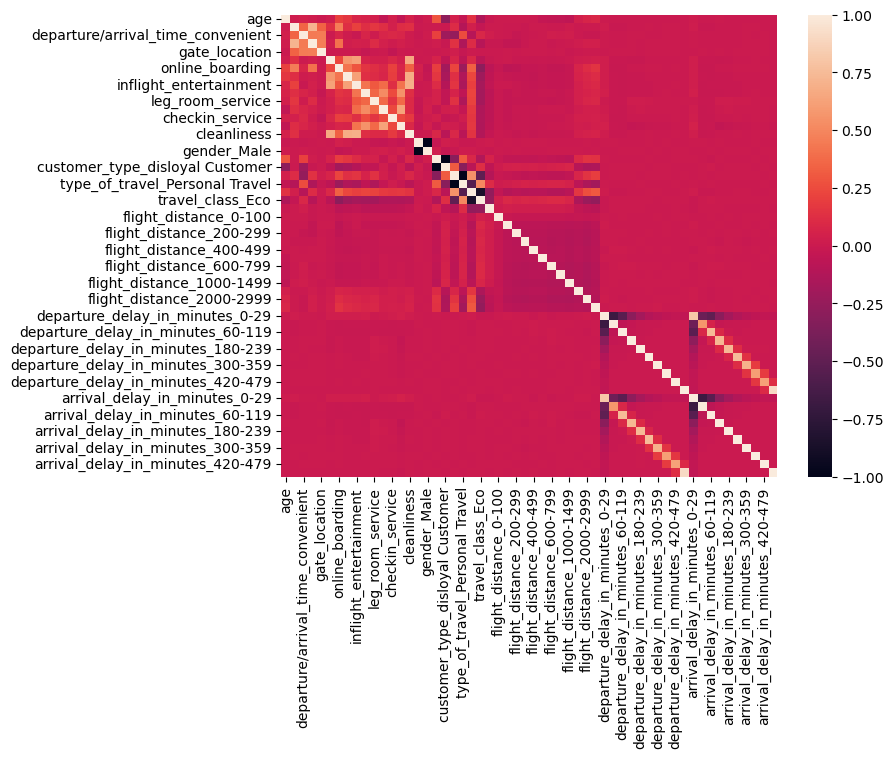

In [96]:
# View possible feature correlations
corrs = X.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corrs)

In [97]:
# Split the preprocessed data into a training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## MACHINE LEARNING EXPERIMENTATION

In [98]:
# FUNCTION FOR CLASSIFICATION

def classificationModeling(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)

    train_results = f"""TRAIN METRICS
    Train Confusion Matrix:
    {train_cf}

    Train Classification Report:
    {train_cr}

    Train AUC: {train_auc}
    """

    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)

    test_results = f"""TEST METRICS
    Test Confusion Matrix:
    {test_cf}

    Test Classification Report:
    {test_cr}

    Test AUC: {test_auc}
    """

    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')

    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

## Logistic Regression

TRAIN METRICS
    Train Confusion Matrix:
    [[49627  5292]
 [ 6887 35309]]

    Train Classification Report:
                             precision    recall  f1-score   support

neutral or dissatisfied       0.88      0.90      0.89     54919
              satisfied       0.87      0.84      0.85     42196

               accuracy                           0.87     97115
              macro avg       0.87      0.87      0.87     97115
           weighted avg       0.87      0.87      0.87     97115


    Train AUC: 0.9272507991936094
    
TEST METRICS
    Test Confusion Matrix:
    [[16540  1766]
 [ 2370 11696]]

    Test Classification Report:
                             precision    recall  f1-score   support

neutral or dissatisfied       0.87      0.90      0.89     18306
              satisfied       0.87      0.83      0.85     14066

               accuracy                           0.87     32372
              macro avg       0.87      0.87      0.87     32372
           we

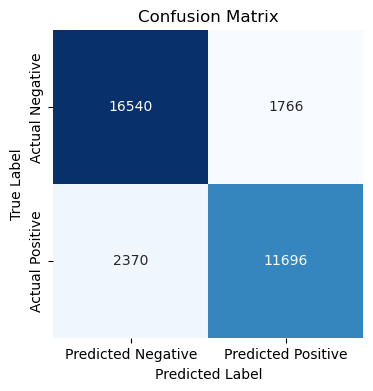

ValueError: y_true takes value in {'neutral or dissatisfied', 'satisfied'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [99]:
# Initiate the model
lr = LogisticRegression()

# Do Machine Learning
classificationModeling(lr, X_train, X_test, y_train, y_test)